# "A breath of fresh air" - ML model training notebook

In [9]:
# import libraries and tools
import pandas as pd
import numpy as np
import missingno as msno
import metpy.calc
from metpy.units import units

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from variable_names import vars_drop

import preprocessing_pipeline as prepro
import feature_engineering as feng

import warnings
warnings.filterwarnings('ignore')

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets


#### Get data and cleaning

In [53]:
# get data
df = pd.read_csv('data/Train.csv')
## Throw out unwanted variables
df.drop(vars_drop, axis=1, inplace=True)
# Convert wind cartesional components to magnitude and direction 
df = feng.create_wind(df)
# Convert time to datetime and create day-of-week column
df = feng.time_features(df)
# Convert target from float into category labels
df = feng.create_target_labels(df)
## Throw out variables with less than 15 features
df.dropna(thresh=15, inplace=True)



#### compile the columns for column density

In [54]:
import re
from sklearn.preprocessing import StandardScaler
list_cols = df.columns.to_list()

r = re.compile(".*column_number*")

newlist = list(filter(r.match, list_cols)) # Read Note below
#print(newlist)

column_densities = df[newlist]

sscal = StandardScaler()

column_densities = sscal.fit_transform(column_densities)
column_densities_mean_scaled = column_densities.sum(axis=1)


df['column_density'] = column_densities_mean_scaled

df.drop(newlist, axis=1, inplace=True)

## Throw out variables with less than 15 features
df = feng.prior_features(df)



KeyError: "['specific_humidity_2m_above_ground'] not in index"

In [ ]:
list_drop_new = ['specific_humidity_2m_above_ground',
                 'specific_humidity_2m_above_ground_prior']

df.drop('specific_humidity_2m_above_ground',axis=1, inplace=True)

['precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'L3_NO2_absorbing_aerosol_index',
 'L3_CLOUD_cloud_fraction',
 'L3_CLOUD_cloud_optical_depth',
 'L3_CLOUD_cloud_top_pressure',
 'L3_CLOUD_surface_albedo',
 'L3_AER_AI_absorbing_aerosol_index',
 'L3_SO2_absorbing_aerosol_index',
 'winddir',
 'windspeed',
 'weekday',
 'column_density',
 'precipitable_water_entire_atmosphere_prior',
 'relative_humidity_2m_above_ground_prior',
 'specific_humidity_2m_above_ground_prior',
 'temperature_2m_above_ground_prior',
 'winddir_prior',
 'windspeed_prior']

#### Define preprocessor and split data

In [45]:
non_qnt_cols = ['Place_ID','Date','Place_ID X Date','target','target_cat']
qnt_cols = [col for col in df.columns.to_list() if col not in non_qnt_cols]
cat_cols = ['Place_ID']

### Define the preprocessor

preprocessor = prepro.make_pipeline(qnt_cols,cat_cols)

## To make time spit, first drop numerical target and unnecessary categories
## Keep target_cat as part of the dataframe

df.drop(['Place_ID X Date','target'], axis=1, inplace=True)
#Perform test train split for time series data
X_train, X_test, y_train, y_test = prepro.test_train_time_split(df,
                                                         target_name='target_cat',
                                                         date_name='Date',
                                                         test_size=0.3)

print(f'X_train shape is{X_train.shape}, y_train shape is {y_train.shape}')
print(f'X_test shape is{X_test.shape}, y_test shape is {y_test.shape}')

X_train shape is(21269, 22), y_train shape is (21269,)
X_test shape is(9115, 22), y_test shape is (9115,)


In [46]:
def print_results(y_true,y_pred):
    print(f"Average class-weighted f-beta score is {fbeta_score(y_true,y_pred,beta=2,average='weighted'):.2f}")
    print('-------'*10)
    #labels = ['Good','Fair','Poor']
    labels = [0,1,2]
    conf = confusion_matrix(y_true,y_pred,labels=labels)
    

    sns.heatmap(conf,annot=True,fmt='g', xticklabels=labels, yticklabels=labels);
    print(classification_report(y_true, y_pred,labels=labels))


## Make a scorer for the gridsearch
fbeta2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')


#### Baseline model

Average class-weighted f-beta score is 0.69
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2274
           1       0.51      0.35      0.41      2365
           2       0.77      0.88      0.82      4476

    accuracy                           0.70      9115
   macro avg       0.65      0.64      0.64      9115
weighted avg       0.68      0.70      0.68      9115



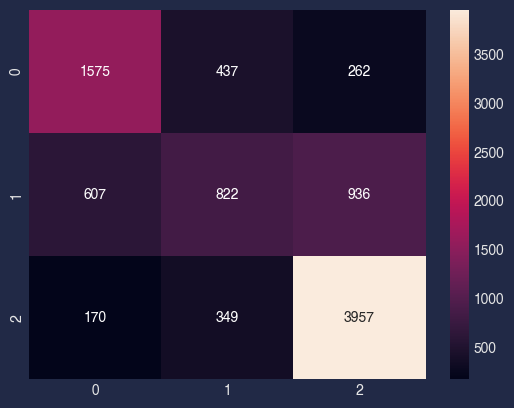

In [47]:
param_grid = {}

### Create a pipeline with the chosen baseline model and preprocessor
base_log = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(n_jobs=-1,max_iter=1000))
])


#Create a gridsearch for cross validation
gs_baseline = GridSearchCV(base_log, param_grid=param_grid, cv=5, scoring=fbeta2_scorer, 
                           verbose=0, n_jobs=-1)


## Fit the model using gridsearch and get best model
gs_baseline.fit(X_train, y_train);
best_model = gs_baseline.best_estimator_

## Make predictions on test set
y_pred = best_model.predict(X_test);

## print the results
print_results(y_test,y_pred);


## Random forest


Average class-weighted f-beta score is 0.58
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      2274
           1       0.61      0.06      0.11      2365
           2       0.61      0.96      0.75      4476

    accuracy                           0.62      9115
   macro avg       0.62      0.52      0.48      9115
weighted avg       0.62      0.62      0.54      9115



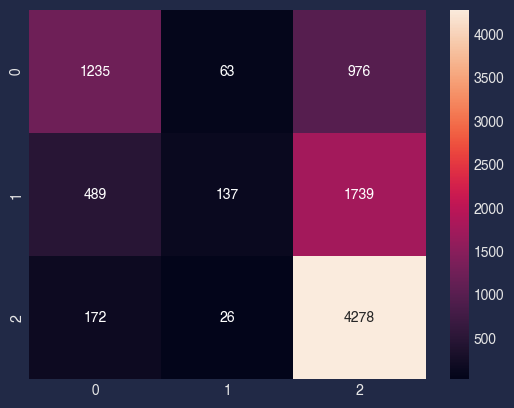

In [7]:
param_grid = {'rmf__n_estimators': range(10,200,5),
              'rmf__max_depth': [None,] + list(range(10,100,5)),
              'rmf__min_samples_leaf': range(1,10),
              'rmf__max_features': ("sqrt","log2",2,5,10)}

### Create a pipeline with the chosen baseline model and preprocessor
rmfor = Pipeline([
    ('preprocessor', preprocessor),
    ('rmf', RandomForestClassifier())
])


#Create a gridsearch for cross validation
rs_rmfor = RandomizedSearchCV(rmfor, param_distributions=param_grid, cv=5, scoring=fbeta2_scorer, 
                           verbose=0, n_jobs=-1, n_iter=15)


## Fit the model using gridsearch and get best model
rs_rmfor.fit(X_train, y_train);
best_model = rs_rmfor.best_estimator_

## Make predictions on test set
y_pred = best_model.predict(X_test);

## print the results
print_results(y_test,y_pred);


In [10]:
param_grid = {}

### Create a pipeline with the chosen baseline model and preprocessor
xgbclass = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbc', XGBClassifier())
])


#Create a gridsearch for cross validation
gs_xgbc = GridSearchCV(xgbclass, param_grid=param_grid, cv=5, 
                           verbose=0, n_jobs=-1)


## Fit the model using gridsearch and get best model
gs_xgbc.fit(X_train, y_train);
best_model = gs_xgbc.best_estimator_

## Make predictions on test set
y_pred = best_model.predict(X_test);

## print the results
print_results(y_test,y_pred);


KeyboardInterrupt: 

In [41]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


reduce_max = 1.5
# roughly 1.5
val_cts = y_train.value_counts()
vc_min = val_cts.min()

vc_rus = (val_cts - vc_min)//2 + vc_min

rus = RandomUnderSampler(sampling_strategy={0: vc_rus[0], 1: vc_rus[1], 2: vc_rus[2]})
ros = RandomOverSampler()

X_res, y_res = rus.fit_resample(X_train,y_train)
X_res, y_res = ros.fit_resample(X_res,y_res)

In [42]:
y_res.value_counts()

0    7966
1    7966
2    7966
Name: target_cat, dtype: int64